# NWA suntans: approximate structure functions


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

from oceans.filters import lanc

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

core_variables = ["eta", "temp", "uc", "vc", "tau_x", "tau_y", "nu_v"]

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    #w = cluster.scale(jobs=10)
    w = cluster.scale(jobs=5)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [5]:
# surface data
ds, grd = nwa.load_surf()
ds = ds.isel(time=slice(0,None,6), Nk=0).persist()

# low
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
ds_low = xr.open_zarr(zarr).isel(time=slice(0,None,6), Nk=0).persist()

In [6]:
# reference point
lon, lat = nwa.moorings["W310"]
idx = nwa.find_point_index(lon, lat, grd)

In [7]:
# take difference with reference point and average
for v in core_variables:
    ds[v] = (ds[v] - ds[v].isel(Nc=idx))**2
    ds_low[v] = (ds_low[v] - ds_low[v].isel(Nc=idx))**2
#ds["ke"] = 0.5*(ds.uc**2+ds.vc**2)

In [8]:
# temporally average
dsm = ds.mean("time").compute()
dsm_low = ds_low.mean("time").compute()

In [9]:
# compute distance with mooring
from pyproj import Geod
g = Geod(ellps="WGS84")
_, _, dl = g.inv(lon + grd.xv*0, lat + grd.yv*0, grd.xv, grd.yv)
dsm["dl"] = (grd.xv.dims, dl/1e3) #km
dsm_low["dl"] = (grd.xv.dims, dl/1e3) #km

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


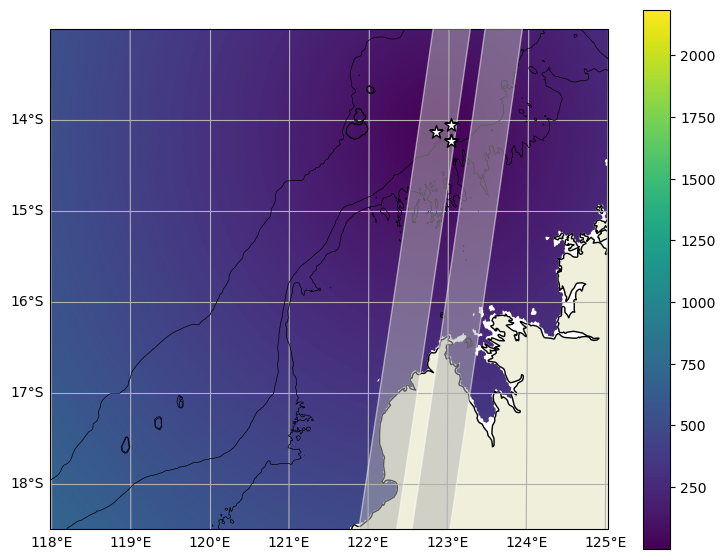

In [10]:
zoom = "cp_large"
zoom = "central"

da = dsm.dl

fig, ax = nwa.map_init(zoom, bathy=(grd, dsm), bathy_kw=dict(colors="k"))
nwa.plot_moorings(ax)

_, _, poly, cbar = grd.suntans.plotcelldata(da, crs=crs) #vmin=0., vmax=.15

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


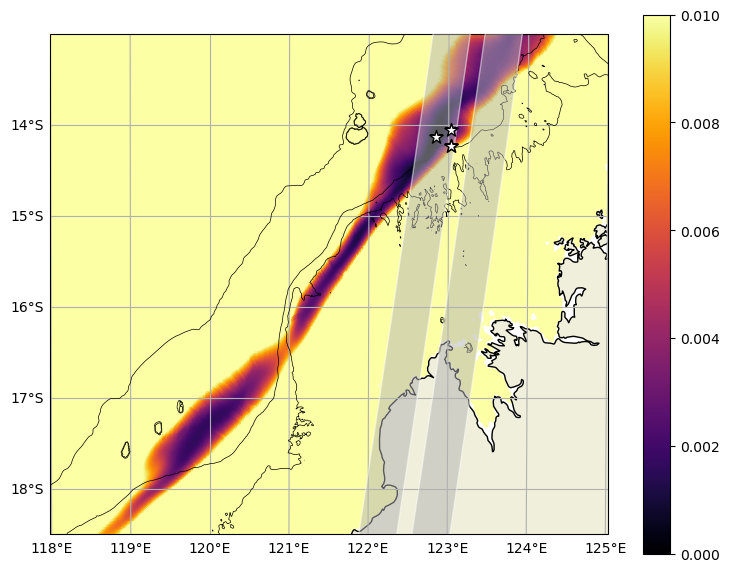

In [30]:
da = dsm.eta

fig, ax = nwa.map_init(zoom, bathy=(grd, dsm), bathy_kw=dict(colors="k"))
nwa.plot_moorings(ax)

_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap="inferno", crs=crs, vmin=0, vmax=(0.1)**2)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


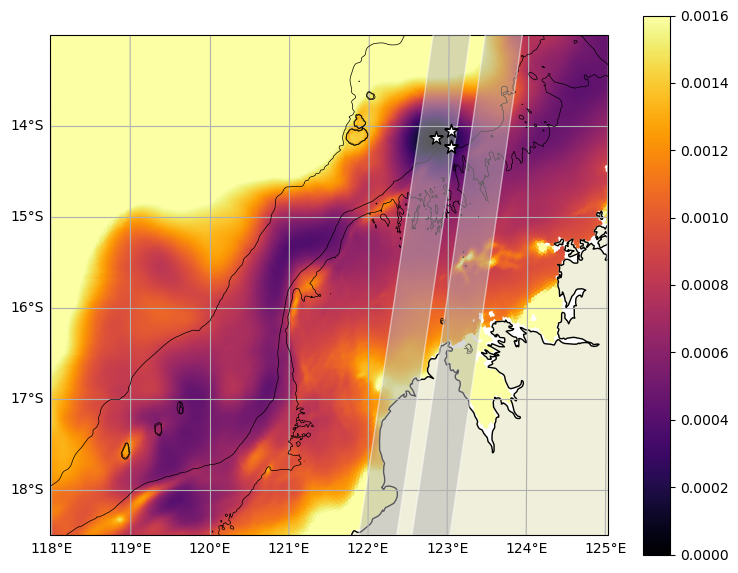

In [12]:
da = dsm_low.eta

fig, ax = nwa.map_init(zoom, bathy=(grd, dsm), bathy_kw=dict(colors="k"))
nwa.plot_moorings(ax)

_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap="inferno", crs=crs, vmin=0., vmax=(4e-2)**2)

### group by distance and average

In [19]:
dsb = dsm.groupby_bins(dsm.dl, np.arange(0,200,1)).mean().rename(dl_bins="r")
dsb_low = dsm_low.groupby_bins(dsm_low.dl, np.arange(0,200,1)).mean().rename(dl_bins="r")

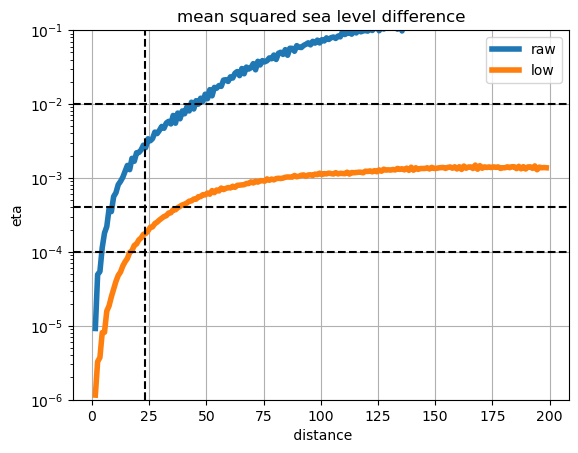

In [26]:
fig, ax = plt.subplots(1,1)
dsb["eta"].plot(lw=4, label="raw")
dsb_low["eta"].plot(lw=4, label="low")

ax.axhline((1e-2)**2, color="k", ls="--")
ax.axhline((2e-2)**2, color="k", ls="--")
ax.axhline((10e-2)**2, color="k", ls="--")
ax.axvline(23, color="k", ls="--") # mooring distance
ax.set_title("mean squared sea level difference")
ax.set_xlabel(" distance")
ax.grid()
ax.legend()
ax.set_ylim((1e-3)**2,.1)
ax.set_yscale("log")

In [27]:
np.sqrt(3e-3)

0.05477225575051661

In [79]:
# compute distance between moorings
for m, c in nwa.moorings.items():
    print(m, g.inv(lon, lat, c[0], c[1]))

W310 (0.0, 180.0, 0.0)
N280 (65.68929892305266, -114.35751230264353, 22781.985498749993)
S245 (116.38000913447999, -63.66736888586232, 23293.134028023334)
L245 (116.06612555592952, -63.98191664383101, 23556.01720233733)


---
## load mean square sea level

In [80]:
zarr = os.path.join(nwa.suntans_dir, "suntans_2km_surf_low_mean")
dsm0 = xr.open_zarr(zarr).isel(Nk=0)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


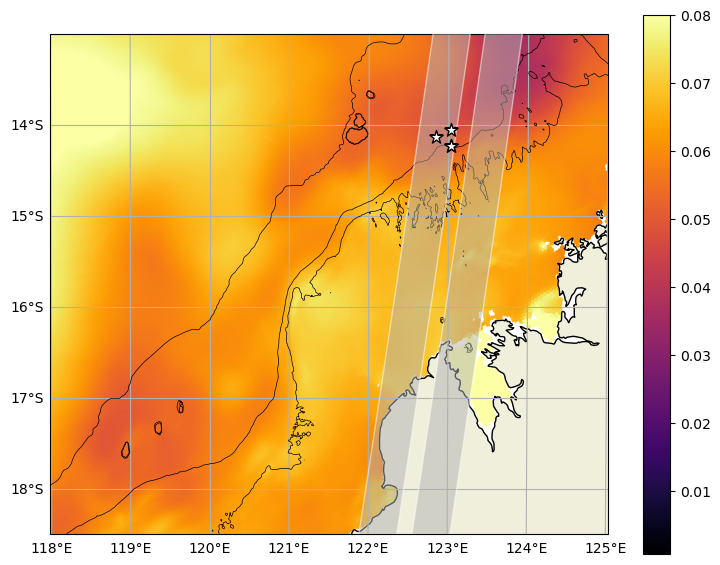

In [88]:
da = np.sqrt(dsm0.eta2)

fig, ax = nwa.map_init(zoom, bathy=(grd, dsm0), bathy_kw=dict(colors="k"))
nwa.plot_moorings(ax)

_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap="inferno", crs=crs, vmax=0.08)

---

In [31]:
cluster.close()